# Emotion Detection

* Method: Experiment with three pretrained models (ResNet18, ResNet50, and VGGFace), evaluate with loss and accuracy, and select the best-performing one.

* Data source: Loaded from [Kaggle](https://www.kaggle.com/datasets/noamsegal/affectnet-training-data/data), no additional input file needed.

* Output file - **emotion_model.pth**: It stores the optimized weights of VGGFace model for later implementation in a system with YOLOv8 face detection.


## Summary of Models' Performance Evaluation

* ResNet18

Despite the relatively **short training time** (around 15 minutes for 10 epochs), the model's final test accuracy of **63.20%** is suboptimal. This underperformance may stem from overfitting. After Epoch 5, although the training loss continued to decrease, the validation loss showed little to no significant improvement. This behavior suggests that the model is beginning to **overfit** to the training data, as it is becoming more specialized to the training set while struggling to generalize to unseen data.

* ResNet50

Resulted in a slightly higher test accuracy of **66.54%**. Throughout the 10 epochs, the validation loss consistently decreased, indicating that the model continued to improve its ability to generalize to unseen data. This suggests that the model is still in the process of learning and could potentially improve with additional epochs. However, training for many more epochs might result in diminishing returns and is **time-consuming**, as it took approximately 40 minutes to run just 10 epochs.

* VGGFace (**Selected**)

Outperformed the other models with a test accuracy of **75.98%**. Although it took 55 minutes for 10 epochs, the accuracy improved significantly. However, the validation loss began to increase after epoch 5, indicating potential overfitting. By using early stopping or adjusting the learning rate, we can mitigate this issue and possibly reduce the training time. Therefore, we have selected VGGFace as our final model choice.

## Requirement

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import cv2
from PIL import Image
import os
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Dataset

In [2]:
# Download dataset from Kaggle Hub
path = kagglehub.dataset_download("noamsegal/affectnet-training-data")

print("Path to dataset files:", path)

100%|██████████| 314M/314M [00:14<00:00, 22.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/3


In [3]:
# Define dataset class for AffectNet
class AffectNetDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file, index_col=0)
        self.img_dir = img_dir
        self.transform = transform

        # Convert labels from text to numeric encoding
        self.label_mapping = {"neutral": 0, "happy": 1, "sad": 2, "surprise": 3, "fear": 4, "disgust": 5, "anger": 6, "contempt": 7}
        self.data['label'] = self.data['label'].map(self.label_mapping)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_filename = str(self.data['pth'][idx])
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")
        label = int(self.data['label'][idx])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Set paths
data_dir = "/root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/3"
csv_file = os.path.join(data_dir, "labels.csv")

# Create dataset
full_dataset = AffectNetDataset(csv_file=csv_file, img_dir=data_dir, transform=transform)

# Split into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

# Count labels in each dataset
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]
print("\nTrain label distribution:", Counter(train_labels))
print("Validation label distribution:", Counter(val_labels))
print("Test label distribution:", Counter(test_labels))

Train set: 22540 images
Validation set: 2817 images
Test set: 2818 images

Train label distribution: Counter({3: 3700, 1: 3437, 6: 2898, 5: 2735, 7: 2615, 4: 2437, 2: 2411, 0: 2307})
Validation label distribution: Counter({3: 468, 1: 463, 6: 352, 5: 348, 4: 312, 2: 310, 7: 295, 0: 269})
Test label distribution: Counter({3: 448, 1: 436, 5: 389, 6: 358, 7: 334, 4: 294, 0: 285, 2: 274})


## Train and Evaluation Functions

In [4]:
# Evaluation function
def evaluate(model, data_loader, criterion=None, return_metrics=False):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute loss if criterion is provided
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(data_loader) if criterion else None

    if return_metrics:
        return avg_loss, accuracy
    else:
        print(f'\nTest Accuracy: {accuracy:.2f}%')

# Train function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        scheduler.step()  # Adjust learning rate

        # Run validation after each epoch
        val_loss, val_acc = evaluate(model, val_loader, criterion, return_metrics=True)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

    return train_losses, val_losses, val_accuracies

# Plot confusion matrix
def get_predictions(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def unnormalize(tensor, mean, std):
    """Reverses normalization for visualization"""
    mean = mean[:, None, None]
    std = std[:, None, None]
    return tensor * std + mean  # Revert normalization

# Visualize predictions
def visualize_predictions(model, test_loader, num_images=10):
    model.eval()
    images_shown = 0
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Display 10 images (2 rows, 5 columns)
    axes = axes.flatten()

    with torch.no_grad():
        for images, labels in test_loader:
            for i in range(len(images)):
                if images_shown >= num_images:
                    break  # Stop after displaying num_images

                image = images[i]
                label = labels[i].item()

                # Unnormalize image before displaying
                image = unnormalize(image.cpu(), mean, std)
                image = torch.clamp(image, 0, 1)  # Ensure values are in [0, 1]

                # Convert tensor to PIL image for visualization
                image_pil = transforms.ToPILImage()(image)

                # Predict emotion
                image_tensor = image.unsqueeze(0).to(device)  # Move to the same device as the model
                outputs = model(image_tensor)
                _, predicted = torch.max(outputs, 1)
                predicted_label = predicted.item()

                # Show image with label
                axes[images_shown].imshow(image_pil)
                axes[images_shown].axis("off")
                axes[images_shown].set_title(f"Pred: {emotion_classes[predicted_label]}\nTrue: {emotion_classes[label]}")

                images_shown += 1

            if images_shown >= num_images:
                break  # Stop after num_images

    plt.tight_layout()
    plt.show()

## ResNet18

In [6]:
# Pretrained ResNet18
class ResNet18Emotion(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet18Emotion, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze early layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Fine-tune only layer4 and fully connected layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Modify the final fully connected (FC) layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model = ResNet18Emotion(num_classes=8).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train and evaluate the model
train_losses_res18, val_losses_res18, val_accuracies_res18 = train(resnet18_model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

# Evaluate model on test set
evaluate(resnet18_model, test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


Epoch 1/10: Train Loss = 1.4634, Val Loss = 1.2216, Val Acc = 55.38%
Epoch 2/10: Train Loss = 1.2112, Val Loss = 1.1573, Val Acc = 55.84%
Epoch 3/10: Train Loss = 1.0904, Val Loss = 1.0874, Val Acc = 59.42%
Epoch 4/10: Train Loss = 1.0274, Val Loss = 1.2063, Val Acc = 52.86%
Epoch 5/10: Train Loss = 0.9929, Val Loss = 1.0377, Val Acc = 60.45%
Epoch 6/10: Train Loss = 0.8685, Val Loss = 0.9848, Val Acc = 63.01%
Epoch 7/10: Train Loss = 0.8446, Val Loss = 1.0097, Val Acc = 63.19%
Epoch 8/10: Train Loss = 0.8265, Val Loss = 1.0086, Val Acc = 62.16%
Epoch 9/10: Train Loss = 0.8200, Val Loss = 0.9823, Val Acc = 63.93%
Epoch 10/10: Train Loss = 0.8092, Val Loss = 0.9930, Val Acc = 63.22%

Test Accuracy: 63.20%


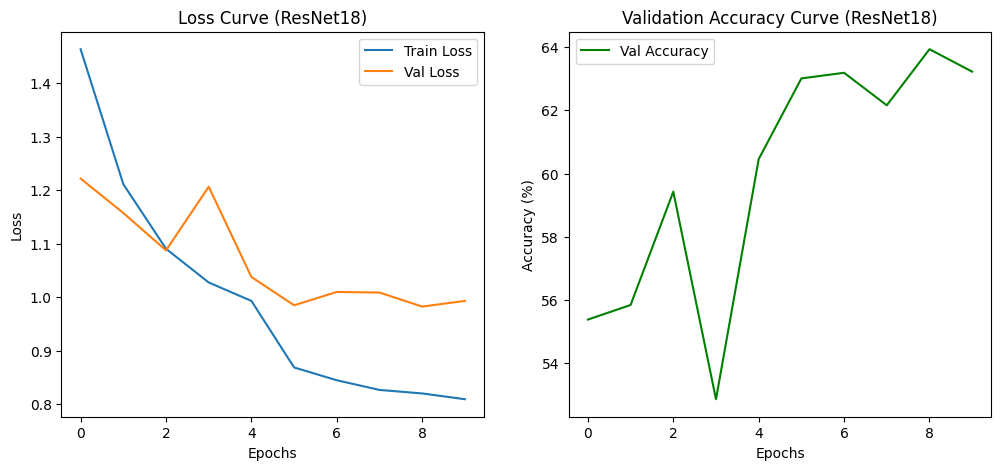

In [7]:
# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_res18, label="Train Loss")
plt.plot(val_losses_res18, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve (ResNet18)")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies_res18, label="Val Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (ResNet18)")
plt.legend()

plt.show()

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       285
           1       0.86      0.82      0.84       436
           2       0.47      0.61      0.53       274
           3       0.61      0.67      0.64       448
           4       0.63      0.55      0.59       294
           5       0.60      0.49      0.54       389
           6       0.62      0.60      0.61       358
           7       0.65      0.69      0.67       334

    accuracy                           0.63      2818
   macro avg       0.62      0.62      0.62      2818
weighted avg       0.63      0.63      0.63      2818



<Figure size 800x600 with 0 Axes>

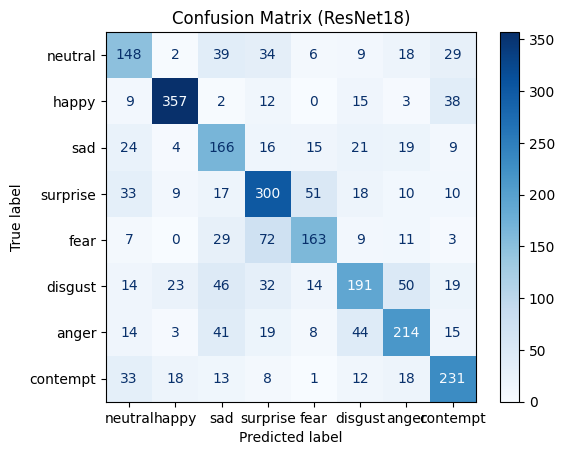

In [8]:
# Get predictions
y_pred, y_true = get_predictions(resnet18_model, test_loader)
print(classification_report(y_true, y_pred))

# Compute confusion matrix
emotion_classes = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "anger", "contempt"]
cm_res18 = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res18, display_labels=emotion_classes)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (ResNet18)")
plt.show()

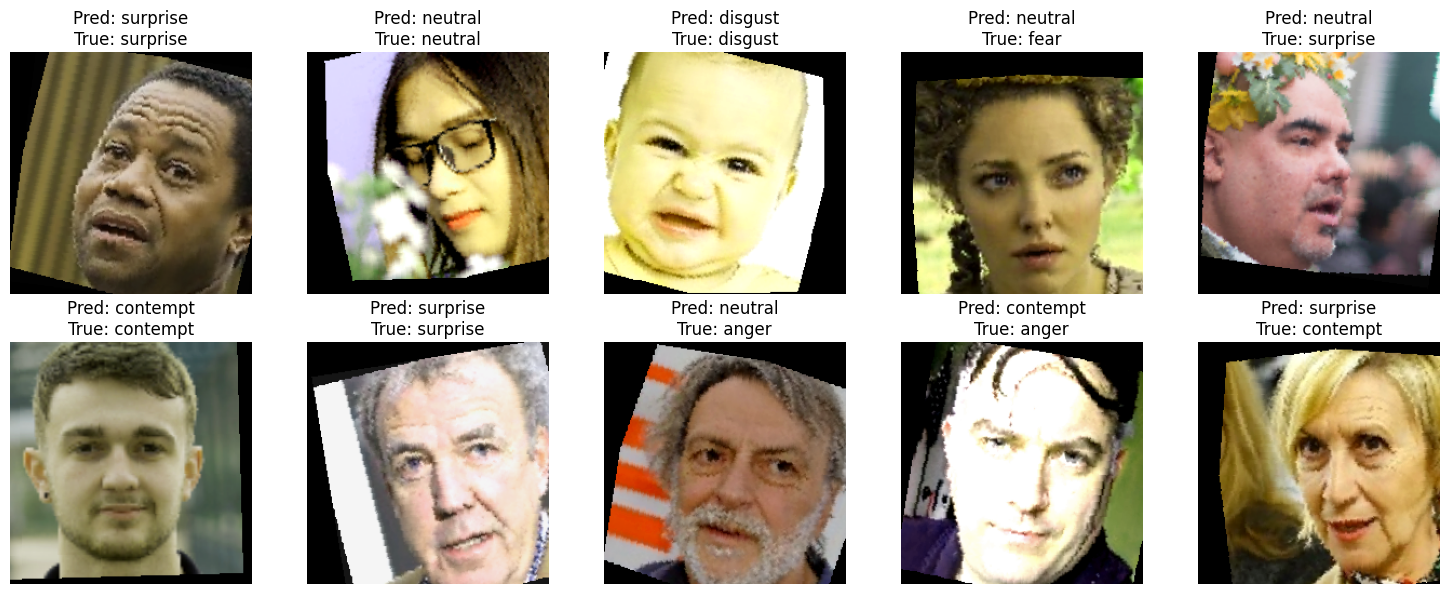

In [9]:
# Run visualization
visualize_predictions(resnet18_model, test_loader, num_images=10)

## ResNet50

In [11]:
# Pretrained ResNet50
class ResNet50Emotion(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNet50Emotion, self).__init__()
        self.model = models.resnet50(pretrained=True)

        # Freeze first few layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Fine-tune deeper layers
        for param in self.model.layer4.parameters():  # Unfreeze layer4 for training
            param.requires_grad = True

        # Modify the final FC layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model = ResNet50Emotion(num_classes=8).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train and evaluate the model
train_losses_res50, val_losses_res50, val_accuracies_res50 = train(resnet50_model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

# Evaluate model on test set
evaluate(resnet50_model, test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 244MB/s]


Epoch 1/10: Train Loss = 1.3840, Val Loss = 1.1855, Val Acc = 55.91%
Epoch 2/10: Train Loss = 1.1709, Val Loss = 1.2344, Val Acc = 53.92%
Epoch 3/10: Train Loss = 1.0420, Val Loss = 1.0687, Val Acc = 59.03%
Epoch 4/10: Train Loss = 0.9754, Val Loss = 1.0444, Val Acc = 60.13%
Epoch 5/10: Train Loss = 0.9282, Val Loss = 0.9655, Val Acc = 63.65%
Epoch 6/10: Train Loss = 0.7906, Val Loss = 0.9231, Val Acc = 65.78%
Epoch 7/10: Train Loss = 0.7518, Val Loss = 0.9104, Val Acc = 65.35%
Epoch 8/10: Train Loss = 0.7380, Val Loss = 0.9129, Val Acc = 67.20%
Epoch 9/10: Train Loss = 0.7289, Val Loss = 0.8955, Val Acc = 66.45%
Epoch 10/10: Train Loss = 0.7129, Val Loss = 0.8823, Val Acc = 66.81%

Test Accuracy: 66.54%


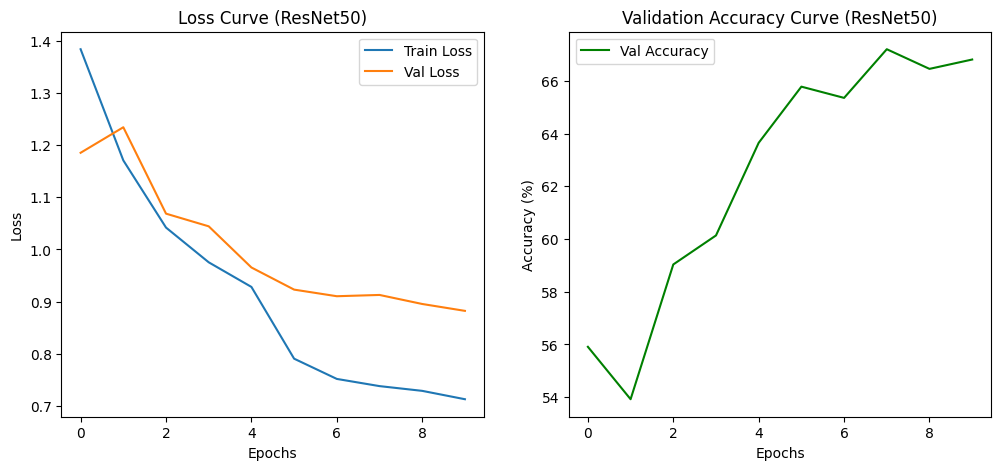

In [12]:
# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_res50, label="Train Loss")
plt.plot(val_losses_res50, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve (ResNet50)")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies_res50, label="Val Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (ResNet50)")
plt.legend()

plt.show()

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       285
           1       0.88      0.83      0.86       436
           2       0.53      0.60      0.56       274
           3       0.62      0.74      0.68       448
           4       0.68      0.65      0.66       294
           5       0.72      0.53      0.61       389
           6       0.63      0.63      0.63       358
           7       0.67      0.74      0.70       334

    accuracy                           0.67      2818
   macro avg       0.66      0.66      0.66      2818
weighted avg       0.68      0.67      0.67      2818



<Figure size 800x600 with 0 Axes>

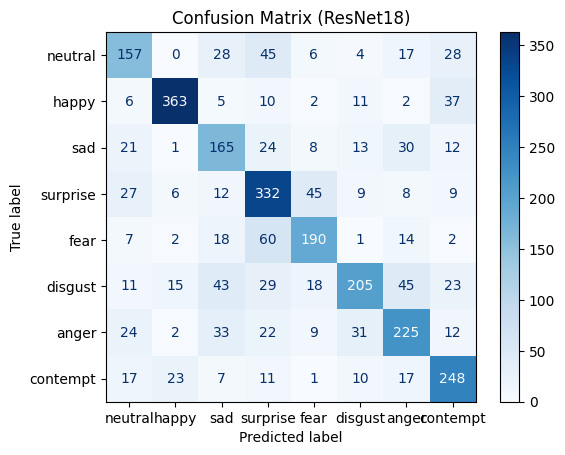

In [13]:
# Get predictions
y_pred, y_true = get_predictions(resnet50_model, test_loader)
print(classification_report(y_true, y_pred))

# Compute confusion matrix
emotion_classes = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "anger", "contempt"]
cm_res50 = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_res50, display_labels=emotion_classes)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (ResNet18)")
plt.show()

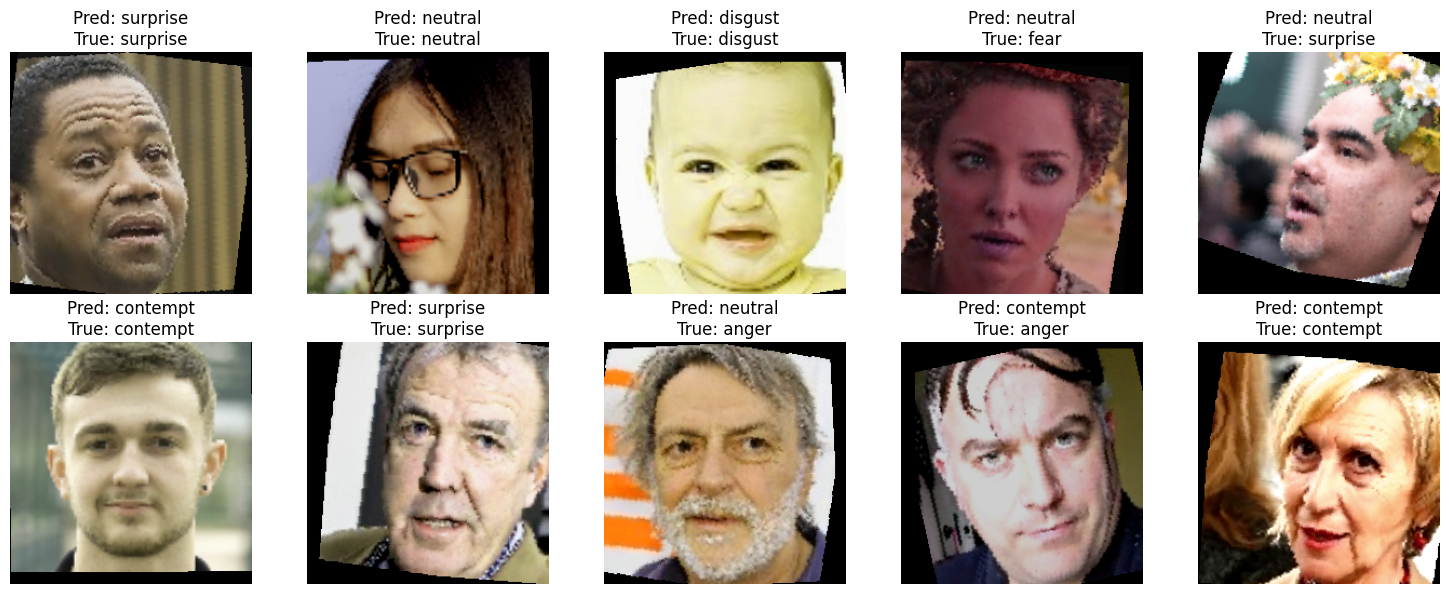

In [14]:
# Run visualization
visualize_predictions(resnet50_model, test_loader, num_images=10)

## VGGFace

In [ ]:
class VGGFaceEmotion(nn.Module):
    def __init__(self, num_classes=8):
        super(VGGFaceEmotion, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_face = VGGFaceEmotion(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_face.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs

train_losses_vgg, val_losses_vgg, val_accuracies_vgg = train(vgg_face, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)
evaluate(vgg_face, test_loader, criterion)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 209MB/s]


Epoch 1/10: Train Loss = 1.4431, Val Loss = 1.1023, Val Acc = 58.89%
Epoch 2/10: Train Loss = 0.9540, Val Loss = 0.9185, Val Acc = 65.74%
Epoch 3/10: Train Loss = 0.7888, Val Loss = 0.8481, Val Acc = 67.73%
Epoch 4/10: Train Loss = 0.6832, Val Loss = 0.7956, Val Acc = 70.75%
Epoch 5/10: Train Loss = 0.6081, Val Loss = 0.7737, Val Acc = 71.10%
Epoch 6/10: Train Loss = 0.3754, Val Loss = 0.7318, Val Acc = 75.08%
Epoch 7/10: Train Loss = 0.3085, Val Loss = 0.7624, Val Acc = 75.26%
Epoch 8/10: Train Loss = 0.2654, Val Loss = 0.7813, Val Acc = 75.33%
Epoch 9/10: Train Loss = 0.2369, Val Loss = 0.8087, Val Acc = 74.94%
Epoch 10/10: Train Loss = 0.2033, Val Loss = 0.8581, Val Acc = 75.54%

Test Accuracy: 75.98%


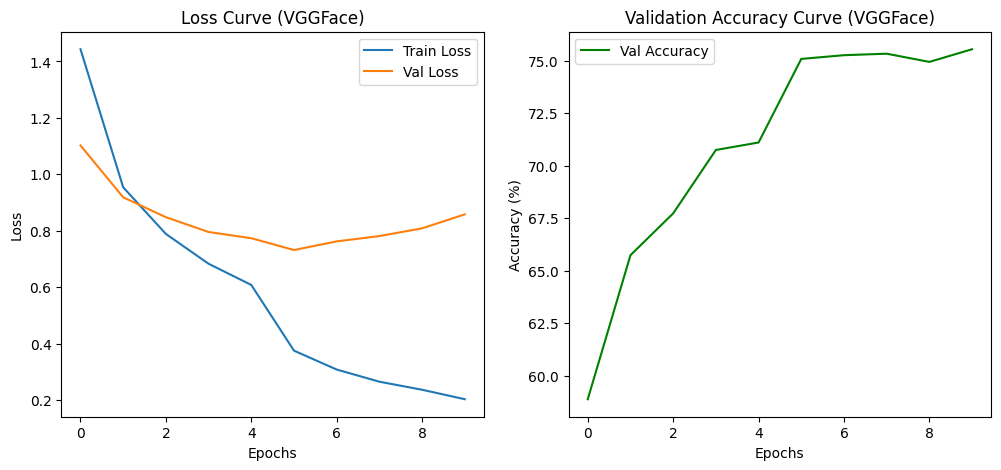

In [ ]:
# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_vgg, label="Train Loss")
plt.plot(val_losses_vgg, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve (VGGFace)")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies_vgg, label="Val Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve (VGGFace)")
plt.legend()

plt.show()

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       287
           1       0.88      0.90      0.89       461
           2       0.74      0.68      0.71       276
           3       0.73      0.83      0.78       431
           4       0.81      0.73      0.77       313
           5       0.75      0.72      0.73       377
           6       0.76      0.72      0.74       359
           7       0.78      0.77      0.77       314

    accuracy                           0.77      2818
   macro avg       0.76      0.76      0.76      2818
weighted avg       0.77      0.77      0.77      2818



<Figure size 800x600 with 0 Axes>

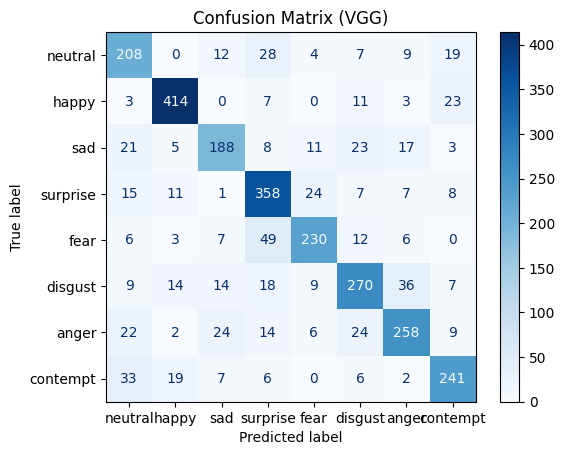

In [ ]:
# Get predictions
y_pred, y_true = get_predictions(vgg_face, test_loader)
print(classification_report(y_true, y_pred))

# Compute confusion matrix
emotion_classes = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "anger", "contempt"]
cm_vgg = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=emotion_classes)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (VGG)")
plt.show()

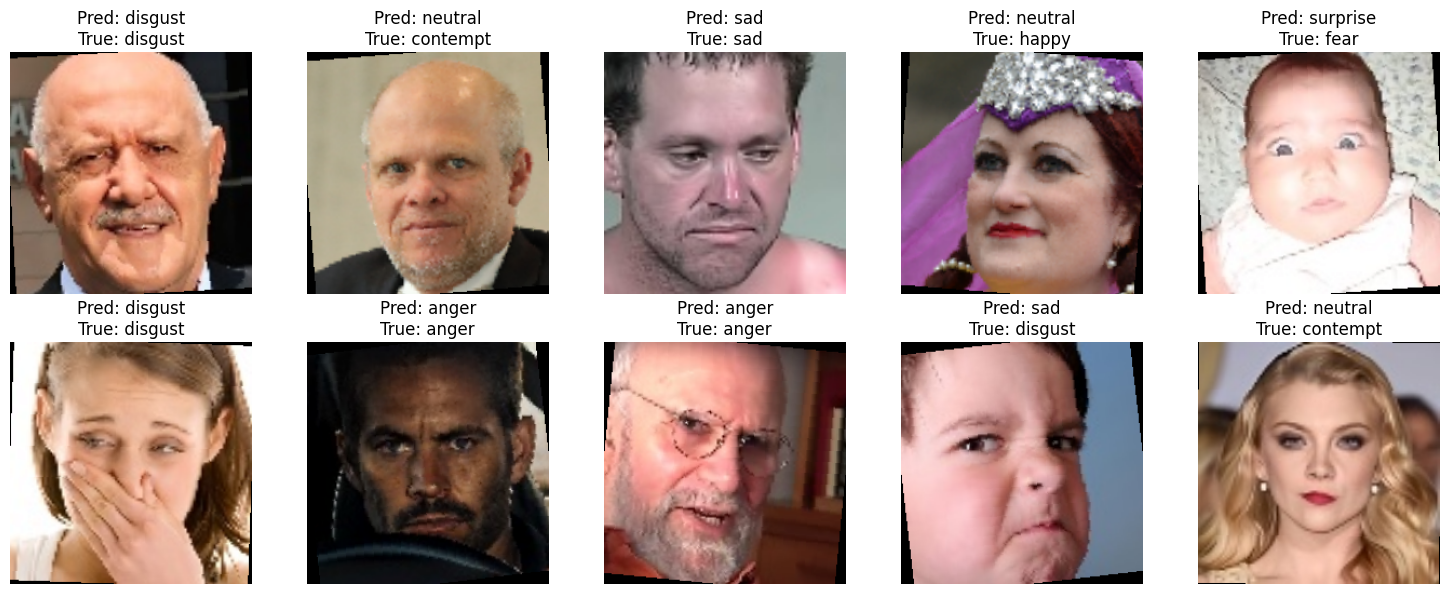

In [ ]:
# Run visualization
visualize_predictions(vgg_face, test_loader, num_images=10)

## Save Best Model - VGGFace

In [ ]:
save_path = "emotion_model.pth"
torch.save(vgg_face.state_dict(), save_path)